In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import math

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=32,
                          padding=4,       
                          padding_mode='reflect'),
    transforms.RandAugment(num_ops=2, magnitude=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, pin_memory=True, num_workers=3)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size*2,
                                         shuffle=False, pin_memory=True, num_workers=3)

Files already downloaded and verified
Files already downloaded and verified


# CA-Net

In [10]:
class CA_Act(nn.Module):
    def __init__(self):
        super(CA_Act, self).__init__()
        self.relu = nn.ReLU6(True)
        
    def forward(self, x):
        out = self.relu(x + 3) / 6
        return x * out
    
class CA_Layer(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(CA_Layer, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        
        middle_channel = max(8, in_channel//32)
        
        self.conv1 = nn.Conv2d(in_channel, middle_channel, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(middle_channel)
        self.conv2 = nn.Conv2d(middle_channel, out_channel, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(middle_channel, out_channel, kernel_size=1, stride=1, padding=0)
        self.relu = CA_Act()
        
    def forward(self, x):
        identity = x
        n, c, h, w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)
        
        y = torch.cat([x_h, x_w], dim=2)
        y = self.relu(self.bn1(self.conv1(y)))
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)
        
        x_h = self.conv2(x_h).sigmoid()
        x_w = self.conv3(x_w).sigmoid()
        x_h = x_h.expand(-1, -1, h, w)
        x_w = x_w.expand(-1, -1, h, w)
        
        out = identity * x_w * x_h
        return out
    
def make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def conv3x3(in_channel, out_channel, stride):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 3, stride, 1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU6(True)
    )

def conv1x1(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 1, 1, 0, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU6(True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, in_channel, out_channel, stride, expansion):
        super(InvertedResidual, self).__init__()
        
        hidden_dim = round(in_channel * expansion)
        self.identity = stride == 1 and in_channel == out_channel
        
        if expansion == 1:
            self.conv = nn.Sequential(
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(True),
                nn.Conv2d(hidden_dim, out_channel, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out_channel),
                nn.ReLU6(True)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channel, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(True),
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(True),
                CA_Layer(hidden_dim, hidden_dim),
                nn.Conv2d(hidden_dim, out_channel, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out_channel),
                nn.ReLU6(True)
            )
    
    def forward(self, x):
        out = self.conv(x)
        if self.identity:
            return out + x
        else:
            return out

class CANet(nn.Module):
    def __init__(self, num_classes=100, width_mult=1.):
        super(CANet, self).__init__()
        self.config = [
            # t, c, n, s
            [1, 32, 1, 1],
            [6, 64, 2, 2],
            [6, 128, 3, 2],
            [6, 192, 2, 2],
            [6, 256, 1, 1],
#             [6, 320, 2, 2],
#             [6, 640, 1, 1],
        ]
        
        in_channel = make_divisible(32*width_mult, 4 if width_mult == 0.1 else 8)
        layers = [conv3x3(3, in_channel, 2)]
        block = InvertedResidual
        for t, c, n, s in self.config:
            out_channel = make_divisible(c * width_mult, 4 if width_mult ==0.1 else 8)
            for i in range(n):
                layers.append(block(in_channel, out_channel, s if i == 0 else 1, t))
                in_channel = out_channel
        self.features = nn.Sequential(*layers)
        
        out_channel =  make_divisible(1280 * width_mult, 4 if width_mult == 0.1 else 8) if width_mult > 1.0 else 1280
        self.conv = conv1x1(in_channel, out_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(out_channel, num_classes)
        )
        self.initialize_weights()
        
    def forward(self, x):
        out = self.features(x)
        out = self.conv(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def adjust_learning_rate(optimizer, current_iter, warmup_iter, max_warm_up_lr):
    if current_iter < warmup_iter:
        lr = max_warm_up_lr * current_iter / warmup_iter
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [12]:
loss_arr = []
acc_arr = []
lr_arr = []

def fit(model, epochs, train_loader, valid_loader, optimizer, lr_scheduler,
        loss_fn, updata_lr_every_epoch, warm_up=False, max_warm_up_lr=0.01, grad_clip=None, PATH='./SKNet.pth'):
    log_interval = int((50000/batch_size)/2)
    for epoch in range(epochs):
        print(f"{'='*20} Epoch: {epoch+1} {'='*20}\n")
        model.train()
        avg_loss = 0
        
        for i, (inputs, targets) in enumerate(train_loader):
            if warm_up != False and epoch <= warm_up:
                adjust_learning_rate(optimizer, (i+1)+epoch*len(train_loader), len(train_loader)*warm_up, max_warm_up_lr=max_warm_up_lr)
                lr_arr.append(get_lr(optimizer))
            outputs = model(inputs.to(device))
            loss = loss_fn(outputs, targets.to(device))
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            if lr_scheduler is not None and updata_lr_every_epoch == False:
                lr_scheduler.step()
                lr_arr.append(get_lr(optimizer))
            optimizer.zero_grad()
            
            avg_loss += loss.item()
            if i % log_interval == log_interval-1:
                avg_loss = avg_loss/log_interval
                print(f"batch: {i+1}, train_loss: {avg_loss:.4f}")
                avg_loss = 0
                
        if lr_scheduler is not None and updata_lr_every_epoch == True:
            lr_scheduler.step()
            lr_arr.append(get_lr(optimizer))
        if lr_scheduler is None:
            lr_arr.append(get_lr(optimizer))
        
        model.eval()
        top1_correct = 0
        top5_correct = 0
        total = 0
        avg_loss = 0
        with torch.no_grad():
            for (images, labels) in valid_loader:
                labels = labels.to(device)
                outputs = model(images.to(device))
                _, predicted = torch.topk(outputs.data, 5, dim=1, largest=True, sorted=True)
                total += labels.cpu().size(0)
                top1_correct += (predicted[:, 0] == labels).sum().item()
                for i in range(len(labels)):
                    if labels[i] in predicted[i]:
                        top5_correct += 1
                avg_loss += loss_fn(outputs, labels)
            avg_loss = avg_loss.cpu() / len(valid_loader)
            loss_arr.append(avg_loss)
            top1_acc = 100 * top1_correct / total
            top5_acc = 100 * top5_correct / total
            acc_arr.append(top1_acc)
            
        print(f'Top1 Accuracy: {top1_acc}% ({top1_correct} / {total}), Top5 Accuracy: {top5_acc}% ({top5_correct} / {total}), Loss: {avg_loss:.3f}, Last_lr: {lr_arr[-1]:.5f}')
    torch.save(model, PATH)

In [13]:
model = CANet().to(device)
num_param = sum([param.nelement() for param in model.parameters()])
print("Number of parameter: %.2fM" % (num_param/1e6))

Number of parameter: 2.73M


In [ ]:
%%time

epochs = 30
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# sched = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.2)
sched = optim.lr_scheduler.OneCycleLR(optimizer, 0.01, epochs=epochs,
                                      steps_per_epoch=len(trainloader))

fit(model=model,
    epochs=epochs,
    train_loader=trainloader,
    valid_loader=testloader,
    optimizer=optimizer,
    lr_scheduler=sched,
    loss_fn=nn.CrossEntropyLoss(),
    warm_up=False, max_warm_up_lr=0.01,
    grad_clip=None, updata_lr_every_epoch=False, PATH='./CANet.pth')

Text(0.5, 1.0, 'loss')

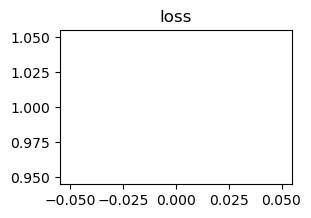

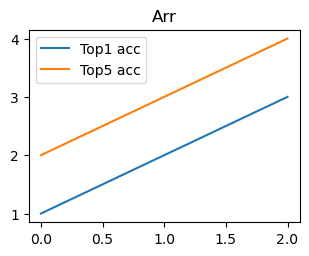

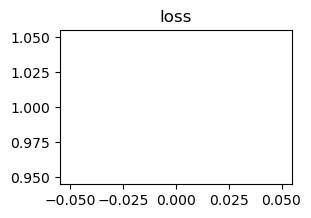

In [8]:
plt.figure(figsize=(3, 2))
plt.plot(loss_arr)
plt.title('loss')

plt.figure(figsize=(3, 2))
plt.plot(acc_arr)
plt.title('Arr')

plt.figure(figsize=(3, 2))
plt.plot(lr_arr)
plt.title('LR')